Considere o **código de Hamming estendido (8, 4)**, obtido a partir do código de Hamming (7, 4) adicionando um "bit de paridade global" no final de cada palavra de código. (Dessa forma, todas as palavras-código terão um número par de bits 1.)

(a) Determine a matriz geradora $G$ para o código.

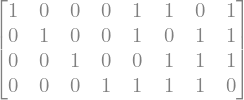

In [8]:
import numpy as np
import itertools as it
import pandas as pd
from sympy import Matrix, init_printing

init_printing()

n = 8
k = 4
m = n - k

G = np.array(
    [
        [1, 0, 0, 0, 1, 1, 0, 1],
        [0, 1, 0, 0, 1, 0, 1, 1],
        [0, 0, 1, 0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 0],
    ]
)

display(Matrix(G))

(b) Construa uma tabela mensagem $\rightarrow$ palavra-código 

In [9]:
u = np.array(list(it.product([0, 1], repeat=k)))
v = (u @ G) % 2

df = pd.DataFrame(columns=["u", "v"])

# df["u"] = ["".join(map(str, x)) for x in u]
# df["v"] = ["".join(map(str, x)) for x in v]
df["u"] = u.tolist()
df["v"] = v.tolist()
df = df.set_index("u")

df

,v
u,
"[0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]"
"[0, 0, 0, 1]","[0, 0, 0, 1, 1, 1, 1, 0]"
"[0, 0, 1, 0]","[0, 0, 1, 0, 0, 1, 1, 1]"
"[0, 0, 1, 1]","[0, 0, 1, 1, 1, 0, 0, 1]"
"[0, 1, 0, 0]","[0, 1, 0, 0, 1, 0, 1, 1]"
"[0, 1, 0, 1]","[0, 1, 0, 1, 0, 1, 0, 1]"
"[0, 1, 1, 0]","[0, 1, 1, 0, 1, 1, 0, 0]"
"[0, 1, 1, 1]","[0, 1, 1, 1, 0, 0, 1, 0]"
"[1, 0, 0, 0]","[1, 0, 0, 0, 1, 1, 0, 1]"


Determine a distância mínima e a distribuição de peso das palavras-código

In [10]:
df["hamm_weight"] = df["v"].apply(lambda x: sum(x))

display(df["hamm_weight"].value_counts().sort_index())

d_min = df["hamm_weight"].sort_values()[1:].min()
print(f"d_min = {d_min}")

hamm_weight
0     1
4    14
8     1
Name: count, dtype: int64

d_min = 4


Determine a matriz de verificação $H$ para o código.

In [11]:
H = np.array(
    [
        [1, 1, 0, 1],
        [1, 0, 1, 1],
        [0, 1, 1, 1],
        [1, 1, 1, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ]
)

df["validated"] = df["v"].apply(lambda x: ((np.array(x).T @ H) % 2))

df

,v,hamm_weight,validated
u,,,
"[0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]",0,"[0, 0, 0, 0]"
"[0, 0, 0, 1]","[0, 0, 0, 1, 1, 1, 1, 0]",4,"[0, 0, 0, 0]"
"[0, 0, 1, 0]","[0, 0, 1, 0, 0, 1, 1, 1]",4,"[0, 0, 0, 0]"
"[0, 0, 1, 1]","[0, 0, 1, 1, 1, 0, 0, 1]",4,"[0, 0, 0, 0]"
"[0, 1, 0, 0]","[0, 1, 0, 0, 1, 0, 1, 1]",4,"[0, 0, 0, 0]"
"[0, 1, 0, 1]","[0, 1, 0, 1, 0, 1, 0, 1]",4,"[0, 0, 0, 0]"
"[0, 1, 1, 0]","[0, 1, 1, 0, 1, 1, 0, 0]",4,"[0, 0, 0, 0]"
"[0, 1, 1, 1]","[0, 1, 1, 1, 0, 0, 1, 0]",4,"[0, 0, 0, 0]"
"[1, 0, 0, 0]","[1, 0, 0, 0, 1, 1, 0, 1]",4,"[0, 0, 0, 0]"


Construa uma tabela de síndrome $\rightarrow$ padrão de erro


In [12]:
import sys
import numpy

numpy.set_printoptions(threshold=sys.maxsize, linewidth=sys.maxsize)

t = np.floor((d_min - 1) / 2)
print(f"t = {t}")

ap = np.zeros((2**m, 2**k, n), dtype=int)

ap[0, :] = np.array(df["v"].tolist())
ap[1:9, 0] = np.eye(n)

for row in range(1, 9):
    for col in range(1, 2**k):
        ap[row, col] = (ap[0, col] + ap[row, 0]) % 2


def to_string(x):
    return "".join(map(str, x))


def to_array(x):
    return np.array(list(x), dtype=int)


possible_words_with_weight_2 = list()

positions = it.combinations(range(n), 2)
for pos in positions:
    error_pattern = np.zeros(n, dtype=int)
    error_pattern[list(pos)] = 1
    possible_words_with_weight_2.append(to_string(error_pattern))


for row in range(9, 2**k):
    next_error_pattern = to_array(possible_words_with_weight_2.pop(0))

    ap[row, 0] = next_error_pattern
    for col in range(1, 2**k):
        ap[row, col] = (ap[0, col] + ap[row, 0]) % 2
        if sum(ap[row, col]) == 2:
            possible_words_with_weight_2.remove(to_string(ap[row, col]))


w_matrix = np.zeros((2**m, 2**k), dtype=int)
for row in range(0, 2**m):
    for col in range(0, 2**k):
        w_matrix[row, col] = sum(ap[row, col])


# Convert each 2D sub-array into a concatenated string and store in a 2D array
str_2d = np.array(["".join(map(str, row)) for layer in ap for row in layer]).reshape(
    ap.shape[0], -1
)

str_2d.shape

t = 1.0


In [70]:
display(H.T.shape)
display(ap[:, 0, :].T.shape)

syndrome = (H.T @ ap[:, 0, :].T) % 2
display(syndrome.T.shape)
syndrome.T

e_s = pd.DataFrame(columns=["syndrome", "error"])

e_s["syndrome"] = [x for x in syndrome.T]
e_s["error"] = [x for x in ap[:, 0, :]]

e_s

,syndrome,error
0,"[0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]"
1,"[1, 1, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 0]"
2,"[1, 0, 1, 1]","[0, 1, 0, 0, 0, 0, 0, 0]"
3,"[0, 1, 1, 1]","[0, 0, 1, 0, 0, 0, 0, 0]"
4,"[1, 1, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0]"
5,"[1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0]"
6,"[0, 1, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0]"
7,"[0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0]"
8,"[0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 1]"
9,"[0, 1, 1, 0]","[1, 1, 0, 0, 0, 0, 0, 0]"


In [14]:
e_s["error"].apply(lambda x: sum(to_array(x))).value_counts().sort_index()

error
0    1
1    8
2    7
Name: count, dtype: int64

### Questão 2

In [135]:
import numpy as np
import komm

n = 8
k = 4
m = n - k
syndrome_to_error = {tuple(s): e for s, e in zip(e_s["syndrome"], e_s["error"])}

u = np.random.randint(0, 2, (100_000, 4))
v = (u @ G) % 2

qpsk_mod = komm.PSKModulation(4)

SNR = range(-1, 8)  # dB
ber = np.zeros(len(SNR))
ber_hamm = np.zeros(len(SNR))

for i, snr in enumerate(SNR):
    snr_lin = 10 ** (snr / 10)
    awgn = komm.AWGNChannel(signal_power="measured", snr=snr_lin)

    v_mod = qpsk_mod.modulate(v.flatten())
    vb = awgn(v_mod)
    v_demod = qpsk_mod.demodulate(vb).reshape(-1, 8)

    s = ((H.T @ v_demod.T) % 2).T

    errors = np.array([syndrome_to_error[tuple(x)] for x in s])
    v_hat = (v_demod + errors) % 2

    ber_hamm[i] = np.sum(v_hat.reshape(-1) != v.reshape(-1)) / 100_000

    u_mod = qpsk_mod.modulate(u.flatten())
    ub = awgn(u_mod)
    u_hat = qpsk_mod.demodulate(ub).reshape(-1, 4)

    ber[i] = np.sum(u_hat.reshape(-1) != u.reshape(-1)) / 100_000

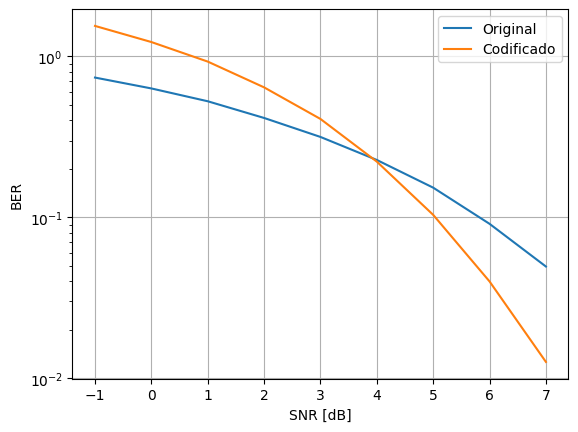

In [136]:
import matplotlib.pyplot as plt

plt.figure()

plt.semilogy(SNR, ber, label="Original")
plt.semilogy(SNR, ber_hamm, label="Codificado")

plt.xlabel("SNR [dB]")
plt.ylabel("BER")

plt.legend()
plt.grid()

plt.show()